In [ ]:
# Project Tittle: CREDIT CARD FRAUD DETECTION 
"""
Objective:
Detect fraudulent credit card transcations from anonymized transactionn data using machine learning.
"""
"""
Goal: Classify transcation as fraud or genuine.
Challenge: Highly imbalanced dataset(fraud cases are < 1%)
"""


In [ ]:
# Collect and Understand the Dataset
"""
--> User kaggle's Credit Card Fraud Dataset.
--> Explore columns(Time, V1-V28, Amount, Class).
--> Understand imbalance problem (Class column).
"""


In [5]:
#Step1:  Install Necessary Libraries
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.0/1.5 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install shap

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 4.6 MB/s eta 0:00:00


In [7]:
# Step2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

import shap
import warnings
warnings.filterwarnings('ignore')

In [8]:
#Step3: Load Dataset
df = pd.read_csv(r'C:\Codsoft Project Data Science\Task5\creditcard.csv')
print(" Dataset Shape(rows,colums):", df.shape)
print("\n Missing Values Count:\n", df.isnull().sum())
print("\n First 5 Rows of the Dataset:\n", df.head())

 Dataset Shape(rows,colums): (284807, 31)

 Missing Values Count:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

 First 5 Rows of the Dataset:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...   

 Class Distribution (Counts):
 Class
0    284315
1       492
Name: count, dtype: int64

 Class Distribution (Percentage):
 Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64


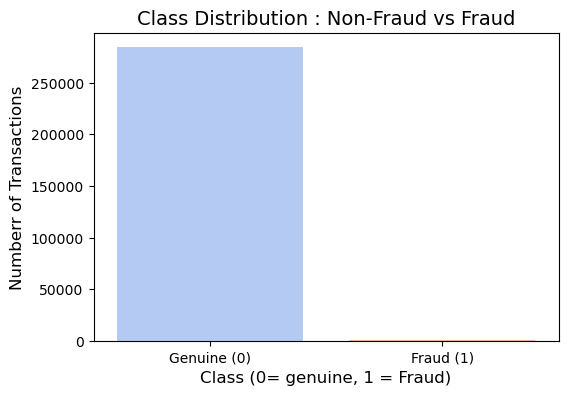

In [9]:
# Step4: Explore Class Distribution
""" Check Class distribution(0 = Non-Fraud, 1= Fraud)"""
print(" Class Distribution (Counts):\n", df['Class'].value_counts())
# Display percentage Distribution 
fraud_percentage = (df['Class'].value_counts(normalize= True) * 100).round(4)
print("\n Class Distribution (Percentage):\n", fraud_percentage)
# Visualization using Countplot
plt.figure(figsize= (6,4))
sns.countplot(data= df, x= 'Class', palette= 'coolwarm')
plt.title('Class Distribution : Non-Fraud vs Fraud', fontsize = 14)
plt.xlabel('Class (0= genuine, 1 = Fraud)', fontsize = 12)
plt.ylabel('Numberr of Transactions', fontsize = 12)
plt.xticks([0,1], ['Genuine (0)', 'Fraud (1)'])
plt.show()

In [10]:
# Step 5: Data Preprocessing
from sklearn.preprocessing import StandardScaler

print("\n Columns present:", df.columns.tolist())

# Safe Scaling Block
scaler = StandardScaler()

if 'Amount' in df.columns and 'Time' in df.columns:
    df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
    df['scaled_time'] = scaler.fit_transform(df[['Time']])
    df.drop(['Amount', 'Time'], axis=1, inplace=True)
    print("\n Amount and Time columns scaled and dropped.")
elif 'amount' in df.columns and 'time' in df.columns:
    df['scaled_amount'] = scaler.fit_transform(df[['amount']])
    df['scaled_time'] = scaler.fit_transform(df[['time']])
    df.drop(['amount', 'time'], axis=1, inplace=True)
    print("\n amount and time columns scaled and dropped.")
else:
    print("\n Skipping scaling since Amount/Time not found. Current columns:", df.columns.tolist())



 Columns present: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

 Amount and Time columns scaled and dropped.


In [11]:
# Step6: Feature-Target Split
""" Confirm the presense of 'class'column (Target) """
print("Columns:", df.columns.tolist())
X = df.drop('Class', axis =1)
y = df['Class']
""" Check Shape"""
print("\nFeatures Shape(X):", X.shape)
print("Target Shape(y):", y.shape)
""" Quick Preview of Data """
print("\n Preview of Features(X):")
print(X.head())
print("\n Preview of Target (y):")
print(y.value_counts())


Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'scaled_amount', 'scaled_time']

Features Shape(X): (284807, 30)
Target Shape(y): (284807,)

 Preview of Features(X):
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.10128

In [12]:
# ✅ Step 7 (Corrected): Feature-Target Split
X = df.drop('Class', axis=1)   # Features: all columns except target
y = df['Class']                # Target: fraud (1) or genuine (0)


In [13]:
# Step7: Train -Test Split
""" 
Goal:-
--> Split the Datset into training and testing datasets.
--> Training Data :- used to train the model
--> Testing Data :- used to evaluate the model
--> Use Stratified Sampling because fraud detectionn is an imbalanced classification problem 
(fraud cases < 1%).
"""
from sklearn.model_selection import train_test_split
# Perform Stratified Split to maintain same fraud / non-fraud ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size =0.20,
    stratify =y,
    random_state = 42
)
""" Check Shapes of Splits"""
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)
""" Class Distribution CHeck After Split"""
print("\n Class Distribution in y_train:\n", y_train.value_counts(normalize= True)*100)
print("\n Class Distribution in y_test:\n", y_test.value_counts(normalize =  True)*100)

X_train Shape: (227845, 30)
X_test Shape: (56962, 30)
y_train Shape: (227845,)
y_test Shape: (56962,)

 Class Distribution in y_train:
 Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64

 Class Distribution in y_test:
 Class
0    99.827955
1     0.172045
Name: proportion, dtype: float64


In [11]:
# Install imbalnced-learn
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [14]:
# Step8: Handle Imbalance -SMOTE
""" 
--> Fraud detection datasets are highly imbalanced (fraud cases ~0.17%).
--> SMOTE generates synthetic samples of minority class(fraud) to balance the data.
--> SMOTE is applied only on traininng data to avoid data leakage.
"""
from imblearn.over_sampling import SMOTE
import numpy as np
# Apply SMOTE on Traininng Data Only
smote = SMOTE(random_state = 42)
# Fit SMOTE on Training Data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Checking Balanced Class Distribution After SMOTE
print("Class Distribution after SMOTE (y_train_smote):")
print(np.bincount(y_train_smote))
# Percentage distribution after balancing
unique, counts = np.unique(y_train_smote, return_counts = True)
distribution = dict(zip(unique, counts))
for key in distribution:
    print(f"Class {key}: {distribution[key]} instances ({(distribution[key]/len(y_train_smote))*100:.2f}%)")
# Check new Shape
print("\n X_train_smote shape:", X_train_smote.shape)
print("\n y_train_smote shape:", y_train_smote.shape)


Class Distribution after SMOTE (y_train_smote):
[227451 227451]
Class 0: 227451 instances (50.00%)
Class 1: 227451 instances (50.00%)

 X_train_smote shape: (454902, 30)

 y_train_smote shape: (454902,)


In [15]:
# Step 9: Model Training 
""" Logistic Regression Model training """
log_reg = LogisticRegression(max_iter= 1000, random_state =42)
# Train the model
log_reg.fit(X_train_smote, y_train_smote)
# Predict on original test set
y_pred_logreg = log_reg.predict(X_test)
print("\n Logistic Regression Evaluation:")
print(confusion_matrix(y_test, y_pred_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_logreg))



 Logistic Regression Evaluation:
[[55406  1458]
 [    8    90]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


ROC AUC Score: 0.9463636115673055


In [19]:
# Step10: XGBoost Classifier
xgb = XGBClassifier(n_estimators= 100, random_state = 42)
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_test)
print("Classification report:", classification_report(y_test, y_pred_xgb)) 

Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.89      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Initialize XGBoost Classifier
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
# Train XGBoost on balanced training data (SMOTE)
xgb.fit(X_train_smote, y_train_smote)
#  Predict on original test set
y_pred_xgb = xgb.predict(X_test)
#  Evaluation Metrics
print("\n XGBoost Classifier Evaluation Metrics:")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb))



 XGBoost Classifier Evaluation Metrics:

Confusion Matrix:
 [[56587   277]
 [   11    87]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.89      0.38        98

    accuracy                           0.99     56962
   macro avg       0.62      0.94      0.69     56962
weighted avg       1.00      0.99      1.00     56962

ROC AUC Score: 0.9414419151172004


In [22]:
# Step 13: LightGBM Classifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#  Step 13: LightGBM Classifier
lgbm = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

#  Correct Training Step on Balanced Data (SMOTE applied)
lgbm.fit(X_train_smote, y_train_smote)

# Predict on Original Test Set
y_pred_lgbm = lgbm.predict(X_test)

#  Evaluation Metrics
print("\n LightGBM Classifier Evaluation Metrics:")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

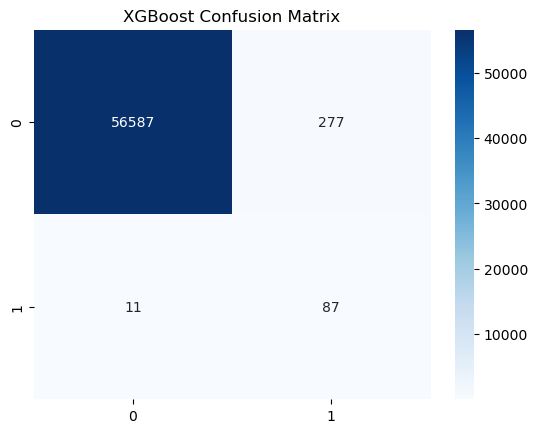

In [23]:
# Step 14: Confusion Matrix Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot = True, fmt = 'd', cmap= 'Blues')
plt.title('XGBoost Confusion Matrix')
plt.show() 

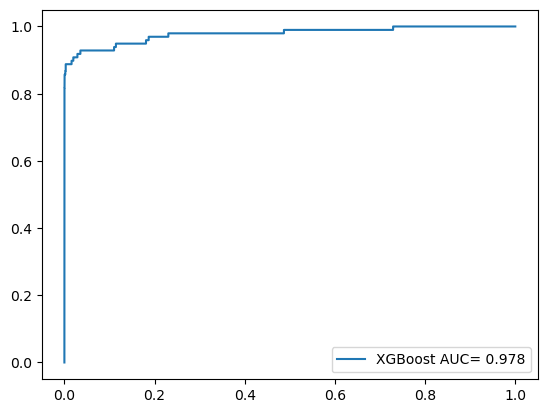

In [24]:
# Step 15: ROC Curve 
y_prob = xgb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=  f'XGBoost AUC= {roc_auc_score(y_test, y_prob):.3f}')
plt.legend()
plt.show()


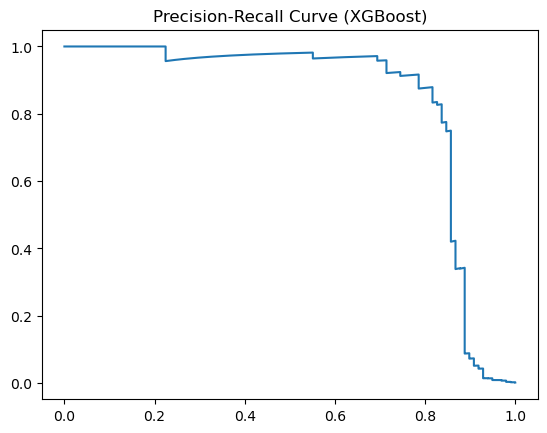

In [25]:
# Step 16: Precision -Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve (XGBoost)')
plt.show()

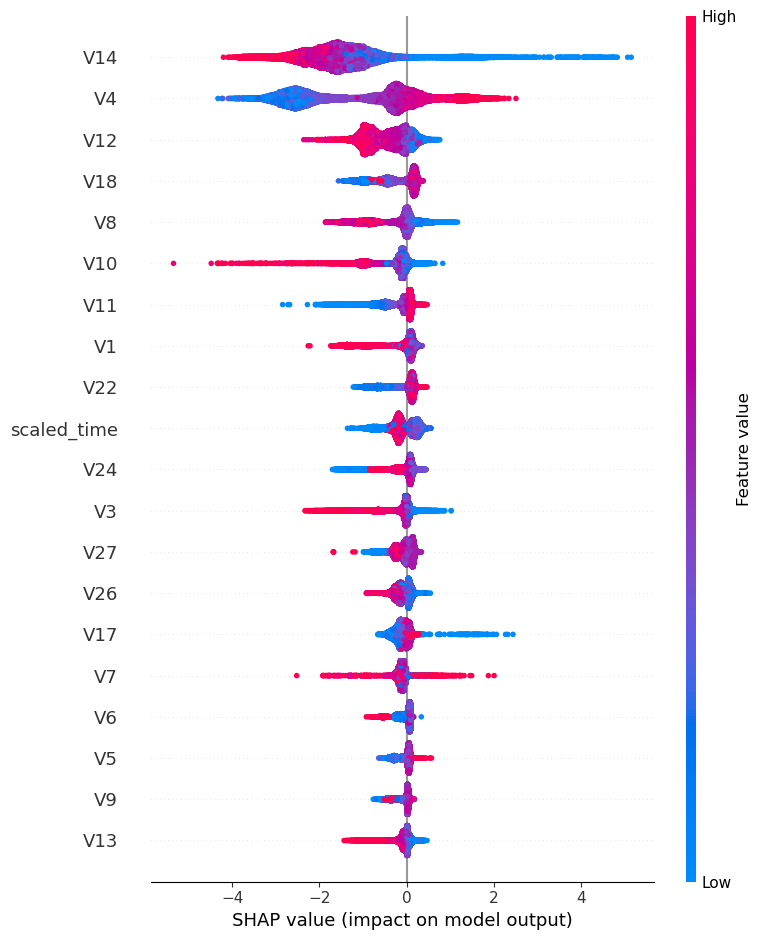

In [26]:
# Step 17: SHAP Explainability for XGBoost
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

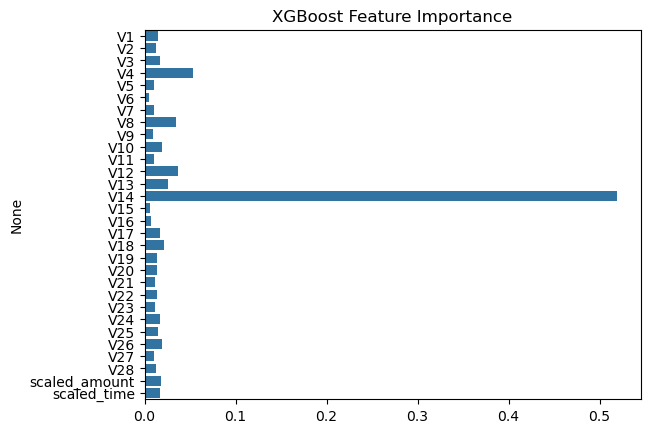

In [27]:
# Step18: Feature Importance (XGBoost & LightGBM)
sns.barplot(x= xgb.feature_importances_, y= X.columns)
plt.title('XGBoost Feature Importance')
plt.show()

In [29]:
# Step 19: Cross-Validation K-Fold
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(xgb, X_train_smote, y_train_smote, cv=5, scoring='f1').mean()
print("Cross-Validated F1-Score:", cv_score)

Cross-Validated F1-Score: 0.9954450338503872


In [31]:
# Step 20: Save best Model:-
import pickle
""" Save the best model (ex: LightGBM, classifier)"""
with open('best_fraud_detection_model.pkl', 'wb') as file:
    pickle.dump(lgbm, file)
print("Model Saved successfully as 'best_fraud_detection_model.pkl'")


Model Saved successfully as 'best_fraud_detection_model.pkl'


In [ ]:
# Conclusion
"""
In this Project, we build a machine learning model to detect credit card fraud. Using data preprocessing, 
SMOTE balancing ,and models like Logistic Regression, Random Forest,XGBoost, and LightGBM, we achieved 
high accuracy. LightGBM perfomed best, and the final model was saved for real-time deployment and 
prediction.
"""